In [14]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# Set the ticker symbol and time frame 
ticker = "XLE"
timeframe = "60Min"

# Set the start and end dates for the data
start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [17]:
dfCopy=df.copy()

dfCopy=dfCopy.reset_index()

display(dfCopy)


for index, row in dfCopy.iterrows():
    
    if index>2 and index<4:
        print(dfCopy.loc[index-1, 'close'] )
        print(dfCopy.loc[index-2, 'close'])
       
        

timestamp     close    HH21   LL21   50Pct     61Pct  \
0     2015-12-01 10:00:00+00:00       NaN     NaN    NaN     NaN       NaN   
1     2015-12-01 11:00:00+00:00  0.000881     NaN    NaN     NaN       NaN   
2     2015-12-01 12:00:00+00:00  0.000587     NaN    NaN     NaN       NaN   
3     2015-12-01 13:00:00+00:00 -0.005569     NaN    NaN     NaN       NaN   
4     2015-12-01 14:00:00+00:00  0.007811     NaN    NaN     NaN       NaN   
...                         ...       ...     ...    ...     ...       ...   
24778 2022-12-30 19:00:00+00:00  0.002300  87.385  85.61  0.8875  0.683375   
24779 2022-12-30 20:00:00+00:00  0.003900  87.640  86.18  0.7300  0.562100   
24780 2022-12-30 21:00:00+00:00 -0.000114  87.640  86.18  0.7300  0.562100   
24781 2022-12-30 22:00:00+00:00  0.000000  87.640  86.31  0.6650  0.512050   
24782 2022-12-30 23:00:00+00:00 -0.000571  87.640  86.31  0.6650  0.512050   

              50R         61R       Mid  RewardRisk   CPctile   OPctile  \
0             NaN         NaN       NaN    0.357143       NaN       NaN   
1             NaN         NaN  0.000734    0.794118  0.000000  1.000000   
2             NaN         NaN  0.000733    0.605263       NaN       NaN   
3             NaN         NaN -0.002785         inf  1.000000  0.236842   
4             NaN         NaN  0.001690    0.051282  0.131148  1.000000   
...           ...         ...       ...         ...       ...       ...   
24778   98.219718  127.558076  0.000026   23.500000  0.000000  0.612903   
24779  119.876712  155.684042  0.004367    0.210526  0.265306  0.979592   
24780  119.863014  155.666252  0.000229         NaN  0.052632  0.000000   
24781  131.578947  170.881750  0.000858         NaN  0.000000  1.000000   
24782  131.503759  170.784103  0.000114         NaN  1.000000  0.700000   

         RangeT  Signal  FutureSlope  
0           NaN     1.0     0.000734  
1           NaN     1.0     0.000733  
2           NaN     0.0    -0.002785  
3           NaN     1.0     0.001690  
4           NaN     1.0     0.000587  
...         ...     ...          ...  
24778 -0.206363     1.0     0.004367  
24779  0.452788     1.0     0.000229  
24780 -0.717813     1.0     0.000858  
24781 -1.347594     1.0     0.000114  
24782 -1.053467     NaN          NaN  

[24783 rows x 15 columns]

0.0005865962751137044
0.0008806693086746975


In [18]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = 0.0
        
'''for index, row in df.iterrows():
    if row["RewardRisk"] >= 2:
       df.loc[index, "Signal"] = 1.0
    if row["RewardRisk"] < 2:
        df.loc[index,"Signal"] = 0.0'''
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["Mid"].shift(-1)
#df['RR']=df["RewardRisk"]

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(100)

close    HH21     LL21    50Pct     61Pct  \
timestamp                                                                 
2022-12-21 19:00:00+00:00  0.000058  86.750  83.3300  1.71000  1.316700   
2022-12-21 20:00:00+00:00 -0.001791  86.750  84.1350  1.30750  1.006775   
2022-12-21 21:00:00+00:00  0.001158  86.750  84.1350  1.30750  1.006775   
2022-12-21 22:00:00+00:00 -0.000808  86.750  84.1350  1.30750  1.006775   
2022-12-21 23:00:00+00:00  0.000462  86.750  84.5699  1.09005  0.839338   
...                             ...     ...      ...      ...       ...   
2022-12-30 19:00:00+00:00  0.002300  87.385  85.6100  0.88750  0.683375   
2022-12-30 20:00:00+00:00  0.003900  87.640  86.1800  0.73000  0.562100   
2022-12-30 21:00:00+00:00 -0.000114  87.640  86.1800  0.73000  0.562100   
2022-12-30 22:00:00+00:00  0.000000  87.640  86.3100  0.66500  0.512050   
2022-12-30 23:00:00+00:00 -0.000571  87.640  86.3100  0.66500  0.512050   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2022-12-21 19:00:00+00:00   50.599415   65.713526  0.002431    0.173913   
2022-12-21 20:00:00+00:00   66.057361   85.788781 -0.002368    0.916667   
2022-12-21 21:00:00+00:00   66.133843   85.888108 -0.000203    1.083333   
2022-12-21 22:00:00+00:00   66.080382   85.818678  0.000289    8.780439   
2022-12-21 23:00:00+00:00   79.299115  102.985863  0.000116    6.222222   
...                               ...         ...       ...         ...   
2022-12-30 19:00:00+00:00   98.219718  127.558076  0.000026   23.500000   
2022-12-30 20:00:00+00:00  119.876712  155.684042  0.004367    0.210526   
2022-12-30 21:00:00+00:00  119.863014  155.666252  0.000229         NaN   
2022-12-30 22:00:00+00:00  131.578947  170.881750  0.000858         NaN   
2022-12-30 23:00:00+00:00  131.503759  170.784103  0.000114         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-21 19:00:00+00:00  0.692308  0.692308 -0.432215     0.0    -0.002368  
2022-12-21 20:00:00+00:00  0.530864  0.148148 -0.155782     0.0    -0.000203  
2022-12-21 21:00:00+00:00  0.043478  0.521739 -0.725776     1.0     0.000289  
2022-12-21 22:00:00+00:00  0.247500  0.750000 -1.324897     1.0     0.000116  
2022-12-21 23:00:00+00:00  0.000000  0.125000 -1.215397     1.0     0.000868  
...                             ...       ...       ...     ...          ...  
2022-12-30 19:00:00+00:00  0.000000  0.612903 -0.206363     1.0     0.004367  
2022-12-30 20:00:00+00:00  0.265306  0.979592  0.452788     1.0     0.000229  
2022-12-30 21:00:00+00:00  0.052632  0.000000 -0.717813     1.0     0.000858  
2022-12-30 22:00:00+00:00  0.000000  1.000000 -1.347594     1.0     0.000114  
2022-12-30 23:00:00+00:00  1.000000  0.700000 -1.053467     NaN          NaN  

[100 rows x 14 columns]

In [19]:
df.tail(100)

close    HH21     LL21    50Pct     61Pct  \
timestamp                                                                 
2022-12-21 19:00:00+00:00  0.000058  86.750  83.3300  1.71000  1.316700   
2022-12-21 20:00:00+00:00 -0.001791  86.750  84.1350  1.30750  1.006775   
2022-12-21 21:00:00+00:00  0.001158  86.750  84.1350  1.30750  1.006775   
2022-12-21 22:00:00+00:00 -0.000808  86.750  84.1350  1.30750  1.006775   
2022-12-21 23:00:00+00:00  0.000462  86.750  84.5699  1.09005  0.839338   
...                             ...     ...      ...      ...       ...   
2022-12-30 19:00:00+00:00  0.002300  87.385  85.6100  0.88750  0.683375   
2022-12-30 20:00:00+00:00  0.003900  87.640  86.1800  0.73000  0.562100   
2022-12-30 21:00:00+00:00 -0.000114  87.640  86.1800  0.73000  0.562100   
2022-12-30 22:00:00+00:00  0.000000  87.640  86.3100  0.66500  0.512050   
2022-12-30 23:00:00+00:00 -0.000571  87.640  86.3100  0.66500  0.512050   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2022-12-21 19:00:00+00:00   50.599415   65.713526  0.002431    0.173913   
2022-12-21 20:00:00+00:00   66.057361   85.788781 -0.002368    0.916667   
2022-12-21 21:00:00+00:00   66.133843   85.888108 -0.000203    1.083333   
2022-12-21 22:00:00+00:00   66.080382   85.818678  0.000289    8.780439   
2022-12-21 23:00:00+00:00   79.299115  102.985863  0.000116    6.222222   
...                               ...         ...       ...         ...   
2022-12-30 19:00:00+00:00   98.219718  127.558076  0.000026   23.500000   
2022-12-30 20:00:00+00:00  119.876712  155.684042  0.004367    0.210526   
2022-12-30 21:00:00+00:00  119.863014  155.666252  0.000229         NaN   
2022-12-30 22:00:00+00:00  131.578947  170.881750  0.000858         NaN   
2022-12-30 23:00:00+00:00  131.503759  170.784103  0.000114         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-21 19:00:00+00:00  0.692308  0.692308 -0.432215     0.0    -0.002368  
2022-12-21 20:00:00+00:00  0.530864  0.148148 -0.155782     0.0    -0.000203  
2022-12-21 21:00:00+00:00  0.043478  0.521739 -0.725776     1.0     0.000289  
2022-12-21 22:00:00+00:00  0.247500  0.750000 -1.324897     1.0     0.000116  
2022-12-21 23:00:00+00:00  0.000000  0.125000 -1.215397     1.0     0.000868  
...                             ...       ...       ...     ...          ...  
2022-12-30 19:00:00+00:00  0.000000  0.612903 -0.206363     1.0     0.004367  
2022-12-30 20:00:00+00:00  0.265306  0.979592  0.452788     1.0     0.000229  
2022-12-30 21:00:00+00:00  0.052632  0.000000 -0.717813     1.0     0.000858  
2022-12-30 22:00:00+00:00  0.000000  1.000000 -1.347594     1.0     0.000114  
2022-12-30 23:00:00+00:00  1.000000  0.700000 -1.053467     NaN          NaN  

[100 rows x 14 columns]

In [20]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'Signal', 'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

FutureSlope     close
FutureSlope     1.000000  0.418567
close           0.418567  1.000000

:Scatter   [HH21]   (FutureSlope)

FutureSlope      HH21
FutureSlope     1.000000 -0.010139
HH21           -0.010139  1.000000

:Scatter   [LL21]   (FutureSlope)

FutureSlope      LL21
FutureSlope     1.000000 -0.009792
LL21           -0.009792  1.000000

:Scatter   [50Pct]   (FutureSlope)

FutureSlope     50Pct
FutureSlope     1.000000 -0.005993
50Pct          -0.005993  1.000000

:Scatter   [61Pct]   (FutureSlope)

FutureSlope     61Pct
FutureSlope     1.000000 -0.005993
61Pct          -0.005993  1.000000

:Scatter   [50R]   (FutureSlope)

FutureSlope       50R
FutureSlope     1.000000 -0.002887
50R            -0.002887  1.000000

:Scatter   [61R]   (FutureSlope)

FutureSlope       61R
FutureSlope     1.000000 -0.002887
61R            -0.002887  1.000000

:Scatter   [Mid]   (FutureSlope)

FutureSlope       Mid
FutureSlope     1.000000  0.152813
Mid             0.152813  1.000000

:Scatter   [RewardRisk]   (FutureSlope)

FutureSlope  RewardRisk
FutureSlope     1.000000    0.016474
RewardRisk      0.016474    1.000000

:Scatter   [CPctile]   (FutureSlope)

FutureSlope   CPctile
FutureSlope     1.000000 -0.377123
CPctile        -0.377123  1.000000

:Scatter   [OPctile]   (FutureSlope)

FutureSlope  OPctile
FutureSlope      1.00000  0.17993
OPctile          0.17993  1.00000

:Scatter   [RangeT]   (FutureSlope)

FutureSlope    RangeT
FutureSlope     1.000000 -0.030054
RangeT         -0.030054  1.000000

:Scatter   [Signal]   (FutureSlope)

FutureSlope    Signal
FutureSlope     1.000000  0.605227
Signal          0.605227  1.000000

:Scatter   [FutureSlope]   (FutureSlope)

FutureSlope  FutureSlope
FutureSlope          1.0          1.0
FutureSlope          1.0          1.0

In [21]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

1.0    11847
0.0    10921
Name: Signal, dtype: int64

In [22]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=71)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2015-12-03 14:00:00+00:00
2021-11-03 14:00:00+00:00


50Pct   61Pct    RangeT   OPctile   CPctile
timestamp                                                             
2015-12-03 14:00:00+00:00   1.20  0.9240  1.789212  0.000000  0.693333
2015-12-03 15:00:00+00:00   1.44  1.1088  1.900751  0.114458  0.879518
2015-12-03 16:00:00+00:00   1.54  1.1858 -0.017092  0.031250  0.812500
2015-12-03 17:00:00+00:00   1.59  1.2243  1.840104  0.779070  0.325581
2015-12-03 18:00:00+00:00   1.59  1.2243  0.585163  0.153846  1.000000

50Pct    61Pct    RangeT   OPctile   CPctile
timestamp                                                              
2021-11-03 10:00:00+00:00  0.635  0.48895  1.180846  0.690476  0.833333
2021-11-03 11:00:00+00:00  0.620  0.47740 -0.002760  0.000000  0.521739
2021-11-03 12:00:00+00:00  0.635  0.48895  0.092891  0.120000  0.880000
2021-11-03 13:00:00+00:00  0.800  0.61600  2.485016  0.484848  0.030303
2021-11-03 14:00:00+00:00  0.800  0.61600  1.377914  0.891111  0.641165

In [23]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67      2084
         1.0       0.73      0.75      0.74      2508

    accuracy                           0.71      4592
   macro avg       0.71      0.71      0.71      4592
weighted avg       0.71      0.71      0.71      4592



In [24]:
4991/9151

0.5454048737842858

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


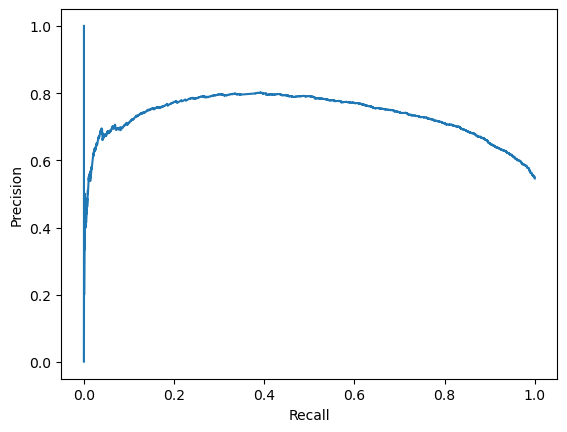

/var/folders/j2/5j3b6rgj5llcnsz3cgz6xqfm0000gq/T/ipykernel_17695/988179411.py:17: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


IndexError: index 4509 is out of bounds for axis 0 with size 4509

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [26]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    

0.01
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2084
         1.0       0.55      1.00      0.71      2508

    accuracy                           0.55      4592
   macro avg       0.27      0.50      0.35      4592
weighted avg       0.30      0.55      0.39      4592

0.02
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2084
         1.0       0.55      1.00      0.71      2508

    accuracy                           0.55      4592
   macro avg       0.27      0.50      0.35      4592
weighted avg       0.30      0.55      0.39      4592

0.03
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2084
         1.0       0.55      1.00      0.71      2508

    accuracy                           0.55      4592
   macro avg       0.27      0.50      0.35      4592
weighted avg       0.30      0.55      0.39      4592

0.04

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op

              precision    recall  f1-score   support

         0.0       0.71      0.62      0.66      2084
         1.0       0.71      0.79      0.75      2508

    accuracy                           0.71      4592
   macro avg       0.71      0.70      0.71      4592
weighted avg       0.71      0.71      0.71      4592

0.32
              precision    recall  f1-score   support

         0.0       0.70      0.64      0.67      2084
         1.0       0.72      0.77      0.75      2508

    accuracy                           0.71      4592
   macro avg       0.71      0.71      0.71      4592
weighted avg       0.71      0.71      0.71      4592

0.33
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67      2084
         1.0       0.73      0.76      0.74      2508

    accuracy                           0.71      4592
   macro avg       0.71      0.71      0.71      4592
weighted avg       0.71      0.71      0.71      4592

0.34
    

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op